In [1]:
import os

# Use the eager mode
os.environ['PT_HPU_LAZY_MODE'] = '0'

# Verify the environment variable is set
print(f"PT_HPU_LAZY_MODE: {os.environ['PT_HPU_LAZY_MODE']}")

import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import habana_frameworks.torch.core as htcore

PT_HPU_LAZY_MODE: 0


Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)


2.4.0a0+git74cd574


/usr/lib/python3.10/inspect.py:288: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(object, types.FunctionType)


In [2]:
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx

## Data Handling in PyG

### Data

Let's create a dummy graph

In [3]:
# use rich traceback

from rich import traceback
traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7ff2801d47c0>>

In [4]:
device = torch.device("hpu")

In [5]:
embeddings = torch.rand((100, 16), dtype=torch.float, device=device)

============================= HABANA PT BRIDGE CONFIGURATION =========================== 
 PT_HPU_LAZY_MODE = 0
 PT_RECIPE_CACHE_PATH = 
 PT_CACHE_FOLDER_DELETE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = 
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 2113407800 KB
------------------------------------------------------------------------------


In [6]:
rows = np.random.choice(100, 500)
cols = np.random.choice(100, 500)
edges = torch.tensor([rows, cols], device=device, dtype=torch.long)

/tmp/ipykernel_1899491/688213010.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /npu-stack/pytorch-fork/torch/csrc/utils/tensor_new.cpp:278.)
  edges = torch.tensor([rows, cols], device=device, dtype=torch.long)


In [7]:
edges_attr = np.random.choice(3,500)

In [8]:
ys = torch.rand((100), device=device).round().long()

Convert the graph information into a PyG Data object

In [9]:
graph = data.Data(x=embeddings, edge_index=edges, edge_attr=edges_attr, y=ys)

In [10]:
graph

Data(x=[100, 16], edge_index=[2, 500], edge_attr=[500], y=[100])

Let's visualize the information contained in the data object

In [11]:
for prop in graph:
    print(prop)

('x', tensor([[0.0269, 0.8503, 0.0673,  ..., 0.8886, 0.1456, 0.5695],
        [0.7757, 0.8296, 0.4634,  ..., 0.1902, 0.1868, 0.1107],
        [0.4896, 0.1219, 0.3136,  ..., 0.3705, 0.3014, 0.1426],
        ...,
        [0.4908, 0.8662, 0.2717,  ..., 0.4143, 0.3589, 0.7990],
        [0.8885, 0.9710, 0.0879,  ..., 0.1803, 0.8750, 0.1741],
        [0.0471, 0.0167, 0.8831,  ..., 0.7889, 0.4448, 0.3477]],
       device='hpu:0'))
('edge_index', tensor([[13, 98, 22, 15, 62, 34,  2,  5,  1, 12, 63, 21, 91, 40, 71, 22,  5, 22,
         13, 28, 97, 79, 54, 61, 51, 59, 57, 97, 12, 66, 57, 31, 15, 31, 35, 70,
         14, 55, 52, 37,  4, 22,  3, 14, 84, 35, 90, 71, 26, 15,  6, 37, 64, 53,
         79, 89, 16, 29, 70, 34, 85, 81, 83, 79, 29, 68, 72, 64, 74,  6, 93, 98,
         30, 83, 43, 85, 92, 38, 36,  2, 27, 63, 88, 90, 83, 31, 76, 21, 55, 51,
         56, 70, 54, 72, 23, 31, 72, 17, 97, 67, 26, 22, 22, 87, 66, 19, 49, 23,
         41, 25, 33, 76, 38, 93, 50, 31, 34, 70, 19, 13, 91, 56, 42, 49

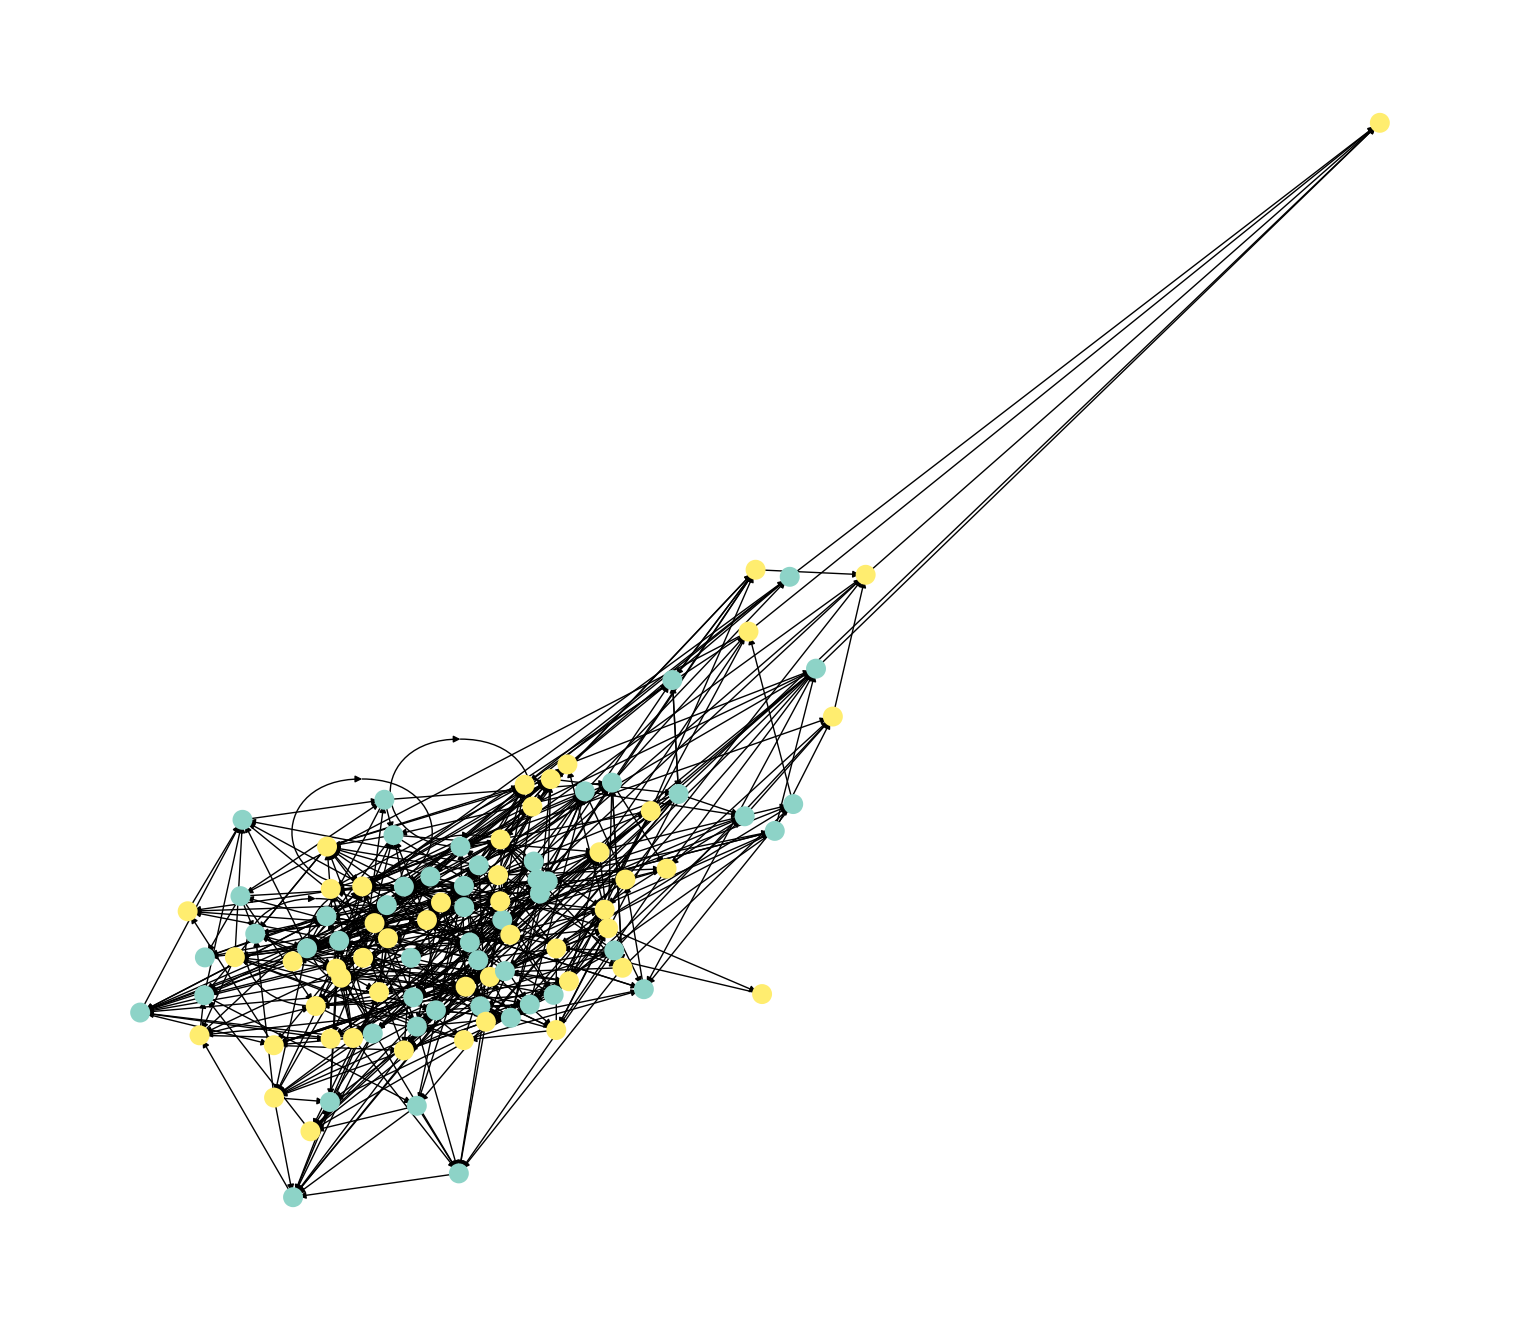

In [12]:
vis = to_networkx(graph)

node_labels = graph.y.cpu().numpy()

import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,13)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=70,linewidths=6)
plt.show()

### Batch

With the Batch object we can represent multiple graphs as a single disconnected graph

In [13]:
graph2 = graph

In [14]:
batch = data.Batch().from_data_list([graph, graph2])

In [15]:
print("Number of graphs:",batch.num_graphs)
print("Graph at index 1:",batch[1])
print("Retrieve the list of graphs:\n",len(batch.to_data_list()))

Number of graphs: 2
Graph at index 1: Data(x=[100, 16], edge_index=[2, 500], edge_attr=[500], y=[100])
Retrieve the list of graphs:
 2


### Cluster

ClusterData groups the nodes of a graph into a specific number of cluster for faster computation in large graphs, then use ClusterLoader to load batches of clusters

In [30]:
torch.ops.load_library("/root/raw_torch_for_scatter/metis/csrc/build/libtsmetis.so")

In [ ]:
# torch_geometric/loader/cluster.py

import copy
import os
import os.path as osp
import sys
from dataclasses import dataclass
from typing import List, Literal, Optional

import torch
import torch.utils.data
from torch import Tensor

import torch_geometric.typing
from torch_geometric.data import Data
from torch_geometric.index import index2ptr, ptr2index
from torch_geometric.io import fs
from torch_geometric.typing import pyg_lib
from torch_geometric.utils import index_sort, narrow, select, sort_edge_index
from torch_geometric.utils.map import map_index


@dataclass
class Partition:
    indptr: Tensor
    index: Tensor
    partptr: Tensor
    node_perm: Tensor
    edge_perm: Tensor
    sparse_format: Literal['csr', 'csc']


class ClusterData(torch.utils.data.Dataset):
    r"""Clusters/partitions a graph data object into multiple subgraphs, as
    motivated by the `"Cluster-GCN: An Efficient Algorithm for Training Deep
    and Large Graph Convolutional Networks"
    <https://arxiv.org/abs/1905.07953>`_ paper.

    .. note::
        The underlying METIS algorithm requires undirected graphs as input.

    Args:
        data (torch_geometric.data.Data): The graph data object.
        num_parts (int): The number of partitions.
        recursive (bool, optional): If set to :obj:`True`, will use multilevel
            recursive bisection instead of multilevel k-way partitioning.
            (default: :obj:`False`)
        save_dir (str, optional): If set, will save the partitioned data to the
            :obj:`save_dir` directory for faster re-use. (default: :obj:`None`)
        filename (str, optional): Name of the stored partitioned file.
            (default: :obj:`None`)
        log (bool, optional): If set to :obj:`False`, will not log any
            progress. (default: :obj:`True`)
        keep_inter_cluster_edges (bool, optional): If set to :obj:`True`,
            will keep inter-cluster edge connections. (default: :obj:`False`)
        sparse_format (str, optional): The sparse format to use for computing
            partitions. (default: :obj:`"csr"`)
    """
    def __init__(
        self,
        data,
        num_parts: int,
        recursive: bool = False,
        save_dir: Optional[str] = None,
        filename: Optional[str] = None,
        log: bool = True,
        keep_inter_cluster_edges: bool = False,
        sparse_format: Literal['csr', 'csc'] = 'csr',
    ):
        assert data.edge_index is not None
        assert sparse_format in ['csr', 'csc']

        self.num_parts = num_parts
        self.recursive = recursive
        self.keep_inter_cluster_edges = keep_inter_cluster_edges
        self.sparse_format = sparse_format

        recursive_str = '_recursive' if recursive else ''
        root_dir = osp.join(save_dir or '', f'part_{num_parts}{recursive_str}')
        path = osp.join(root_dir, filename or 'metis.pt')

        if save_dir is not None and osp.exists(path):
            self.partition = fs.torch_load(path)
        else:
            if log:  # pragma: no cover
                print('Computing METIS partitioning...', file=sys.stderr)

            cluster = self._metis(data.edge_index, data.num_nodes)
            self.partition = self._partition(data.edge_index, cluster)

            if save_dir is not None:
                os.makedirs(root_dir, exist_ok=True)
                torch.save(self.partition, path)

            if log:  # pragma: no cover
                print('Done!', file=sys.stderr)

        self.data = self._permute_data(data, self.partition)

    def _metis(self, edge_index: Tensor, num_nodes: int) -> Tensor:
        # Computes a node-level partition assignment vector via METIS.
        if self.sparse_format == 'csr':  # Calculate CSR representation:
            row, index = sort_edge_index(edge_index, num_nodes=num_nodes)
            indptr = index2ptr(row, size=num_nodes)
        else:  # Calculate CSC representation:
            index, col = sort_edge_index(edge_index, num_nodes=num_nodes,
                                         sort_by_row=False)
            indptr = index2ptr(col, size=num_nodes)

        # Compute METIS partitioning:
        cluster: Optional[Tensor] = None
        
        cluster = torch.ops.torch_sparse.partition(
            indptr.cpu(),
            index.cpu(),
            None,
            self.num_parts,
            self.recursive,
        ).to(edge_index.device)

        return cluster

    def _partition(self, edge_index: Tensor, cluster: Tensor) -> Partition:
        # Computes node-level and edge-level permutations and permutes the edge
        # connectivity accordingly:

        # Sort `cluster` and compute boundaries `partptr`:
        cluster, node_perm = index_sort(cluster, max_value=self.num_parts)
        partptr = index2ptr(cluster, size=self.num_parts)

        # Permute `edge_index` based on node permutation:
        edge_perm = torch.arange(edge_index.size(1), device=edge_index.device)
        arange = torch.empty_like(node_perm)
        arange[node_perm] = torch.arange(cluster.numel(),
                                         device=cluster.device)
        edge_index = arange[edge_index]

        # Compute final CSR representation:
        (row, col), edge_perm = sort_edge_index(
            edge_index,
            edge_attr=edge_perm,
            num_nodes=cluster.numel(),
            sort_by_row=self.sparse_format == 'csr',
        )
        if self.sparse_format == 'csr':
            indptr, index = index2ptr(row, size=cluster.numel()), col
        else:
            indptr, index = index2ptr(col, size=cluster.numel()), row

        return Partition(indptr, index, partptr, node_perm, edge_perm,
                         self.sparse_format)

    def _permute_data(self, data: Data, partition: Partition) -> Data:
        # Permute node-level and edge-level attributes according to the
        # calculated permutations in `Partition`:
        out = copy.copy(data)
        for key, value in data.items():
            if key == 'edge_index':
                continue
            elif data.is_node_attr(key):
                cat_dim = data.__cat_dim__(key, value)
                out[key] = select(value, partition.node_perm, dim=cat_dim)
            elif data.is_edge_attr(key):
                cat_dim = data.__cat_dim__(key, value)
                value = value.tolist()                
                out[key] = select(value, partition.edge_perm, dim=cat_dim)
        out.edge_index = None

        return out

    def __len__(self) -> int:
        return self.partition.partptr.numel() - 1

    def __getitem__(self, idx: int) -> Data:
        node_start = int(self.partition.partptr[idx])
        node_end = int(self.partition.partptr[idx + 1])
        node_length = node_end - node_start

        indptr = self.partition.indptr[node_start:node_end + 1]
        edge_start = int(indptr[0])
        edge_end = int(indptr[-1])
        edge_length = edge_end - edge_start
        indptr = indptr - edge_start

        if self.sparse_format == 'csr':
            row = ptr2index(indptr)
            col = self.partition.index[edge_start:edge_end]
            if not self.keep_inter_cluster_edges:
                edge_mask = (col >= node_start) & (col < node_end)
                row = row[edge_mask]
                col = col[edge_mask] - node_start
        else:
            col = ptr2index(indptr)
            row = self.partition.index[edge_start:edge_end]
            if not self.keep_inter_cluster_edges:
                edge_mask = (row >= node_start) & (row < node_end)
                col = col[edge_mask]
                row = row[edge_mask] - node_start

        out = copy.copy(self.data)

        for key, value in self.data.items():
            if key == 'num_nodes':
                out.num_nodes = node_length
            elif self.data.is_node_attr(key):
                cat_dim = self.data.__cat_dim__(key, value)
                out[key] = narrow(value, cat_dim, node_start, node_length)
            elif self.data.is_edge_attr(key):
                cat_dim = self.data.__cat_dim__(key, value)
                out[key] = narrow(value, cat_dim, edge_start, edge_length)
                if not self.keep_inter_cluster_edges:
                    out[key] = out[key][edge_mask]

        out.edge_index = torch.stack([row, col], dim=0)

        return out

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}({self.num_parts})'


class ClusterLoader(torch.utils.data.DataLoader):
    r"""The data loader scheme from the `"Cluster-GCN: An Efficient Algorithm
    for Training Deep and Large Graph Convolutional Networks"
    <https://arxiv.org/abs/1905.07953>`_ paper which merges partioned subgraphs
    and their between-cluster links from a large-scale graph data object to
    form a mini-batch.

    .. note::

        Use :class:`~torch_geometric.loader.ClusterData` and
        :class:`~torch_geometric.loader.ClusterLoader` in conjunction to
        form mini-batches of clusters.
        For an example of using Cluster-GCN, see
        `examples/cluster_gcn_reddit.py <https://github.com/pyg-team/
        pytorch_geometric/blob/master/examples/cluster_gcn_reddit.py>`_ or
        `examples/cluster_gcn_ppi.py <https://github.com/pyg-team/
        pytorch_geometric/blob/master/examples/cluster_gcn_ppi.py>`_.

    Args:
        cluster_data (torch_geometric.loader.ClusterData): The already
            partioned data object.
        **kwargs (optional): Additional arguments of
            :class:`torch.utils.data.DataLoader`, such as :obj:`batch_size`,
            :obj:`shuffle`, :obj:`drop_last` or :obj:`num_workers`.
    """
    def __init__(self, cluster_data, **kwargs):
        self.cluster_data = cluster_data
        iterator = range(len(cluster_data))
        super().__init__(iterator, collate_fn=self._collate, **kwargs)

    def _collate(self, batch: List[int]) -> Data:
        if not isinstance(batch, torch.Tensor):
            batch = torch.tensor(batch)

        global_indptr = self.cluster_data.partition.indptr
        global_index = self.cluster_data.partition.index

        # Get all node-level and edge-level start and end indices for the
        # current mini-batch:
        node_start = self.cluster_data.partition.partptr[batch]
        node_end = self.cluster_data.partition.partptr[batch + 1]
        edge_start = global_indptr[node_start]
        edge_end = global_indptr[node_end]

        # Iterate over each partition in the batch and calculate new edge
        # connectivity. This is done by slicing the corresponding source and
        # destination indices for each partition and adjusting their indices to
        # start from zero:
        rows, cols, nodes, cumsum = [], [], [], 0
        for i in range(batch.numel()):
            nodes.append(torch.arange(node_start[i], node_end[i]))
            indptr = global_indptr[node_start[i]:node_end[i] + 1]
            indptr = indptr - edge_start[i]
            if self.cluster_data.partition.sparse_format == 'csr':
                row = ptr2index(indptr) + cumsum
                col = global_index[edge_start[i]:edge_end[i]]

            else:
                col = ptr2index(indptr) + cumsum
                row = global_index[edge_start[i]:edge_end[i]]

            rows.append(row)
            cols.append(col)
            cumsum += indptr.numel() - 1

        node = torch.cat(nodes, dim=0)
        row = torch.cat(rows, dim=0)
        col = torch.cat(cols, dim=0)

        # Map `col` vector to valid entries and remove any entries that do not
        # connect two nodes within the same mini-batch:
        if self.cluster_data.partition.sparse_format == 'csr':
            col, edge_mask = map_index(col, node)
            row = row[edge_mask]
        else:
            row, edge_mask = map_index(row, node)
            col = col[edge_mask]
        out = copy.copy(self.cluster_data.data)

        # Slice node-level and edge-level attributes according to its offsets:
        for key, value in self.cluster_data.data.items():
            if key == 'num_nodes':
                out.num_nodes = cumsum
            elif self.cluster_data.data.is_node_attr(key):
                cat_dim = self.cluster_data.data.__cat_dim__(key, value)
                out[key] = torch.cat([
                    narrow(out[key], cat_dim, s, e - s)
                    for s, e in zip(node_start, node_end)
                ], dim=cat_dim)
            elif self.cluster_data.data.is_edge_attr(key):
                cat_dim = self.cluster_data.data.__cat_dim__(key, value)
                value = torch.cat([
                    narrow(out[key], cat_dim, s, e - s)
                    for s, e in zip(edge_start, edge_end)
                ], dim=cat_dim)
                out[key] = select(value, edge_mask, dim=cat_dim)

        out.edge_index = torch.stack([row, col], dim=0)

        return out


In [28]:
data.ClusterData = ClusterData

In [29]:
cluster = data.ClusterData(graph, 5)

Computing METIS partitioning...
Done!


In [31]:
clusterloader = data.ClusterLoader(cluster)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.ClusterLoader' is deprecated, use 'loader.ClusterLoader' instead
  warnings.warn(out)


### Sampler

For each convolutional layer, sample a maximum of nodes from each neighborhood (as in GraphSAGE)

In [ ]:
# torch_geometric/loader/neighbor_sampler.py

from typing import Callable, List, NamedTuple, Optional, Tuple, Union

import torch
from torch import Tensor

# from torch_geometric.typing import SparseTensor
import random


class EdgeIndex(NamedTuple):
    edge_index: Tensor
    e_id: Optional[Tensor]
    size: Tuple[int, int]

    def to(self, *args, **kwargs):
        edge_index = self.edge_index.to(*args, **kwargs)
        e_id = self.e_id.to(*args, **kwargs) if self.e_id is not None else None
        return EdgeIndex(edge_index, e_id, self.size)


# class Adj(NamedTuple):
#     adj_t: SparseTensor
#     e_id: Optional[Tensor]
#     size: Tuple[int, int]

#     def to(self, *args, **kwargs):
#         adj_t = self.adj_t.to(*args, **kwargs)
#         e_id = self.e_id.to(*args, **kwargs) if self.e_id is not None else None
#         return Adj(adj_t, e_id, self.size)


class DenseNeighborSampler(torch.utils.data.DataLoader):
    r"""The neighbor sampler from the `"Inductive Representation Learning on
    Large Graphs" <https://arxiv.org/abs/1706.02216>`_ paper, which allows
    for mini-batch training of GNNs on large-scale graphs where full-batch
    training is not feasible.

    Given a GNN with :math:`L` layers and a specific mini-batch of nodes
    :obj:`node_idx` for which we want to compute embeddings, this module
    iteratively samples neighbors and constructs bipartite graphs that simulate
    the actual computation flow of GNNs.

    More specifically, :obj:`sizes` denotes how much neighbors we want to
    sample for each node in each layer.
    This module then takes in these :obj:`sizes` and iteratively samples
    :obj:`sizes[l]` for each node involved in layer :obj:`l`.
    In the next layer, sampling is repeated for the union of nodes that were
    already encountered.
    The actual computation graphs are then returned in reverse-mode, meaning
    that we pass messages from a larger set of nodes to a smaller one, until we
    reach the nodes for which we originally wanted to compute embeddings.

    Hence, an item returned by :class:`NeighborSampler` holds the current
    :obj:`batch_size`, the IDs :obj:`n_id` of all nodes involved in the
    computation, and a list of bipartite graph objects via the tuple
    :obj:`(edge_index, e_id, size)`, where :obj:`edge_index` represents the
    bipartite edges between source and target nodes, :obj:`e_id` denotes the
    IDs of original edges in the full graph, and :obj:`size` holds the shape
    of the bipartite graph.
    For each bipartite graph, target nodes are also included at the beginning
    of the list of source nodes so that one can easily apply skip-connections
    or add self-loops.

    .. warning::

        :class:`~torch_geometric.loader.NeighborSampler` is deprecated and will
        be removed in a future release.
        Use :class:`torch_geometric.loader.NeighborLoader` instead.

    .. note::

        For an example of using :obj:`NeighborSampler`, see
        `examples/reddit.py
        <https://github.com/pyg-team/pytorch_geometric/blob/master/examples/
        reddit.py>`_ or
        `examples/ogbn_products_sage.py
        <https://github.com/pyg-team/pytorch_geometric/blob/master/examples/
        ogbn_products_sage.py>`_.

    Args:
        edge_index (Tensor or SparseTensor): A :obj:`torch.LongTensor` or a
            :class:`torch_sparse.SparseTensor` that defines the underlying
            graph connectivity/message passing flow.
            :obj:`edge_index` holds the indices of a (sparse) symmetric
            adjacency matrix.
            If :obj:`edge_index` is of type :obj:`torch.LongTensor`, its shape
            must be defined as :obj:`[2, num_edges]`, where messages from nodes
            :obj:`edge_index[0]` are sent to nodes in :obj:`edge_index[1]`
            (in case :obj:`flow="source_to_target"`).
            If :obj:`edge_index` is of type :class:`torch_sparse.SparseTensor`,
            its sparse indices :obj:`(row, col)` should relate to
            :obj:`row = edge_index[1]` and :obj:`col = edge_index[0]`.
            The major difference between both formats is that we need to input
            the *transposed* sparse adjacency matrix.
        sizes ([int]): The number of neighbors to sample for each node in each
            layer. If set to :obj:`sizes[l] = -1`, all neighbors are included
            in layer :obj:`l`.
        node_idx (LongTensor, optional): The nodes that should be considered
            for creating mini-batches. If set to :obj:`None`, all nodes will be
            considered.
        num_nodes (int, optional): The number of nodes in the graph.
            (default: :obj:`None`)
        return_e_id (bool, optional): If set to :obj:`False`, will not return
            original edge indices of sampled edges. This is only useful in case
            when operating on graphs without edge features to save memory.
            (default: :obj:`True`)
        transform (callable, optional): A function/transform that takes in
            a sampled mini-batch and returns a transformed version.
            (default: :obj:`None`)
        **kwargs (optional): Additional arguments of
            :class:`torch.utils.data.DataLoader`, such as :obj:`batch_size`,
            :obj:`shuffle`, :obj:`drop_last` or :obj:`num_workers`.
    """
    def __init__(self, edge_index: Tensor,
                 sizes: List[int], node_idx: Optional[Tensor] = None,
                 num_nodes: Optional[int] = None, return_e_id: bool = True,
                 transform: Callable = None, **kwargs):

        edge_index = edge_index.to('cpu')

        # Remove for PyTorch Lightning:
        kwargs.pop('dataset', None)
        kwargs.pop('collate_fn', None)

        # Save for Pytorch Lightning < 1.6:
        self.edge_index = edge_index
        self.node_idx = node_idx
        self.num_nodes = num_nodes

        self.sizes = sizes
        self.return_e_id = return_e_id
        self.transform = transform
        # self.is_sparse_tensor = isinstance(edge_index, SparseTensor)
        self.__val__ = None

        # Obtain a *transposed* `SparseTensor` instance.        
        if (num_nodes is None and node_idx is not None
                and node_idx.dtype == torch.bool):
            num_nodes = node_idx.size(0)
        if (num_nodes is None and node_idx is not None
                and node_idx.dtype == torch.long):
            num_nodes = max(int(edge_index.max()), int(node_idx.max())) + 1
        if num_nodes is None:
            num_nodes = int(edge_index.max()) + 1
        
        self.num_nodes = num_nodes
        self.value = torch.arange(edge_index.size(1)) if return_e_id else None
        self.row = edge_index[0]
        self.col = edge_index[1]
        self.sparse_sizes = (num_nodes, num_nodes)               
        
        self.adj_list = [[] for _ in range(num_nodes)]
        self.edge_ids = [[] for _ in range(num_nodes)]
        
        for e_id, (src, dst) in enumerate(edge_index.t()):
            self.adj_list[src.item()].append(dst.item())
            if return_e_id:
                self.edge_ids[src.item()].append(e_id)
        
        if node_idx is None:
            node_idx = torch.arange(num_nodes)
        elif node_idx.dtype == torch.bool:
            node_idx = node_idx.nonzero(as_tuple=False).view(-1)

        super().__init__(
            node_idx.view(-1).tolist(), collate_fn=self.sample, **kwargs)

    def sample_neighbors(self, nodes: Tensor, size: int) -> Tuple[Tensor, Tensor, Tensor]:
        """Sample neighbors for given nodes"""
        rows, cols, e_ids = [], [], []
        
        for node in nodes.tolist():
            neighbors = self.adj_list[node]
            if len(neighbors) > 0:
                if size > 0:
                    num_samples = min(size, len(neighbors))
                    sampled_idx = random.sample(range(len(neighbors)), num_samples)
                    sampled_neighbors = [neighbors[i] for i in sampled_idx]
                    if self.return_e_id:
                        sampled_e_ids = [self.edge_ids[node][i] for i in sampled_idx]
                else:
                    sampled_neighbors = neighbors
                    sampled_e_ids = self.edge_ids[node] if self.return_e_id else []
                
                rows.extend([node] * len(sampled_neighbors))
                cols.extend(sampled_neighbors)
                if self.return_e_id:
                    e_ids.extend(sampled_e_ids)
        
        edge_index = torch.tensor([cols, rows], dtype=torch.long)
        e_id = torch.tensor(e_ids) if self.return_e_id else None
        return edge_index, e_id


    def sample(self, batch):
        if not isinstance(batch, Tensor):
            batch = torch.tensor(batch)

        batch_size: int = len(batch)

        adjs = []
        n_id = batch
        for size in self.sizes:
            # adj_t, n_id = self.adj_t.sample_adj(n_id, size, replace=False)
            edge_index, e_id = self.sample_neighbors(n_id, size)
            
            # Get new nodes involved
            new_nodes = torch.unique(edge_index[0])
            n_id = torch.unique(torch.cat([n_id, new_nodes]))
            
            size = (n_id.size(0), len(batch))
            adjs.append(EdgeIndex(edge_index, e_id, size))

        adjs = adjs[0] if len(adjs) == 1 else adjs[::-1]
        out = (batch_size, n_id, adjs)
        out = self.transform(*out) if self.transform is not None else out
        return out

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(sizes={self.sizes})'


In [46]:
data.NeighborSampler = DenseNeighborSampler

In [47]:
sampler = data.NeighborSampler(graph.edge_index, sizes=[3,10], batch_size=4,
                                  shuffle=False)

In [56]:
for s in sampler:
    print(s)
    break

(4, tensor([ 0,  1,  2,  3,  4,  6,  8, 11, 14, 16, 20, 25, 26, 30, 31, 32, 33, 37,
        38, 39, 42, 43, 44, 45, 48, 49, 51, 52, 53, 56, 57, 60, 61, 65, 72, 73,
        74, 75, 76, 82, 83, 86, 87, 94, 97]), [EdgeIndex(edge_index=tensor([[ 3, 86, 75, 94, 14, 32, 61, 57,  6, 74,  8, 49, 39, 26, 65, 73, 53, 30,
         94, 39,  1, 32,  2,  4, 11, 83, 43, 33, 87, 48, 38, 86, 61, 39, 60, 73,
         42, 25, 51, 82, 37, 44, 20, 32, 31, 45, 37, 72,  8, 97, 52, 56, 16, 76],
        [ 1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  8,  8,  8,  8,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 39, 39, 39, 39, 39, 39, 39, 39, 57,
         57, 57, 57, 57, 57, 74, 74, 74, 74, 74, 75, 75, 75, 75, 94, 94, 94, 94]]), e_id=tensor([325, 324,   8, 445, 141, 493, 257, 453, 192,   6,  79, 386,  42, 266,
        492, 415, 262, 245, 100, 197, 285, 242, 127, 236,  48, 203, 321, 195,
        457, 393, 129, 307, 476, 374, 252,  26,  30, 230, 143, 157, 459,  68,
        497, 353, 308, 432, 169, 233, 4

In [57]:
print("Batch size:", s[0])
print("Number of unique nodes involved in the sampling:",len(s[1]))
print("Number of neighbors sampled:", len(s[2][0].edge_index[0]), len(s[2][1].edge_index[0]))

Batch size: 4
Number of unique nodes involved in the sampling: 45
Number of neighbors sampled: 54 8


### Datasets

List all the available datasets

In [58]:
datasets.__all__

['KarateClub',
 'TUDataset',
 'GNNBenchmarkDataset',
 'Planetoid',
 'NELL',
 'CitationFull',
 'CoraFull',
 'Coauthor',
 'Amazon',
 'PPI',
 'Reddit',
 'Reddit2',
 'Flickr',
 'Yelp',
 'AmazonProducts',
 'QM7b',
 'QM9',
 'MD17',
 'ZINC',
 'AQSOL',
 'MoleculeNet',
 'PCQM4Mv2',
 'Entities',
 'RelLinkPredDataset',
 'GEDDataset',
 'AttributedGraphDataset',
 'MNISTSuperpixels',
 'FAUST',
 'DynamicFAUST',
 'ShapeNet',
 'ModelNet',
 'CoMA',
 'SHREC2016',
 'TOSCA',
 'PCPNetDataset',
 'S3DIS',
 'GeometricShapes',
 'BitcoinOTC',
 'GDELTLite',
 'ICEWS18',
 'GDELT',
 'WILLOWObjectClass',
 'PascalVOCKeypoints',
 'PascalPF',
 'SNAPDataset',
 'SuiteSparseMatrixCollection',
 'WordNet18',
 'WordNet18RR',
 'FB15k_237',
 'WikiCS',
 'WebKB',
 'WikipediaNetwork',
 'HeterophilousGraphDataset',
 'Actor',
 'UPFD',
 'GitHub',
 'FacebookPagePage',
 'LastFMAsia',
 'DeezerEurope',
 'GemsecDeezer',
 'Twitch',
 'Airports',
 'LRGBDataset',
 'MalNetTiny',
 'OMDB',
 'PolBlogs',
 'EmailEUCore',
 'LINKXDataset',
 'Elliptic

In [60]:
# https://stackoverflow.com/questions/67064190/attributeerror-in-torch-geometric-transforms
transforms.AddTrainValTestMask = transforms.RandomNodeSplit

name = 'Cora'
transform = transforms.Compose([
    transforms.AddTrainValTestMask('train_rest', num_val=500, num_test=500),
    transforms.TargetIndegree(),
])
cora = datasets.Planetoid('./data', name, pre_transform=transforms.NormalizeFeatures(), transform=transform)

Processing...
Done!


In [61]:
aids = datasets.TUDataset(root="./data", name="AIDS")

Processing...
Done!


In [62]:
print("AIDS info:")
print('# of graphs:', len(aids))
print('# Classes (graphs)', aids.num_classes)
print('# Edge features', aids.num_edge_features)
print('# Edge labels', aids.num_edge_labels)
print('# Node features', aids.num_node_features)

AIDS info:
# of graphs: 2000
# Classes (graphs) 2
# Edge features 3
# Edge labels 3
# Node features 38


In [63]:
print("Cora info:")
print('# of graphs:', len(cora))
print('# Classes (nodes)', cora.num_classes)
print('# Edge features', cora.num_edge_features)
print('# Node features', cora.num_node_features)

Cora info:
# of graphs: 1
# Classes (nodes) 7
# Edge features 1
# Node features 1433


In [ ]:
aids.data

In [ ]:
aids[0]

In [ ]:
cora.data

In [ ]:
cora[0]

In [65]:
cora_loader = data.DataLoader(cora)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [66]:
for l in cora_loader:
    print(l)
    break

DataBatch(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_attr=[10556, 1], batch=[2708], ptr=[2])
